In [1]:
import os
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

from functools import reduce

In [2]:
parent_folder = 'Data'

path = os.path.join(parent_folder, 'DATA_JUNAEB.pkl')
with open(path, 'rb') as path:
    data_JUNAEB = pickle.load(path)

path = os.path.join(parent_folder, 'Colegios(Continental)2020.xlsx')
schools = pd.read_excel(path)

In [4]:
example = data_JUNAEB['Abr']
example['Servicio'] = example['Servicio'].str.strip()

rbds = schools.RBD.values
services = example.Servicio.unique()

In [24]:
unitary_prices = {ser: [] for ser in services}

for rbd in rbds:
    col_data = example[example['Rbd'] == rbd]
    for ser in services:
        raciones = col_data[col_data['Servicio'] == ser]['Rac. Diaria Asig.']
        precio = col_data[col_data['Servicio'] == ser]['Precio Base']
        prec_tot = (raciones * precio).sum()

        if raciones.sum() > 0:
            unitary_prices[ser].append((prec_tot / raciones.sum(), raciones.sum()))
        else:
            unitary_prices[ser].append((0, 0))
    

In [25]:
unitary_prices['RBD'] = list(rbds)

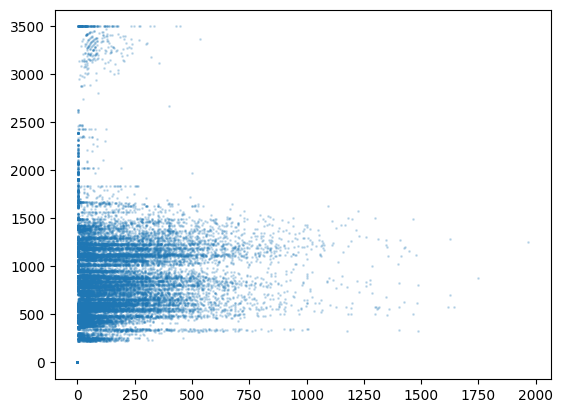

In [55]:
list_servs = list(services)
list_servs.remove('CAN')
new_list = [values for key, values in unitary_prices.items() if key in list_servs]

massive = reduce(lambda x, y: x + y, new_list)

y = [value[0] for value in massive]
x = [value[1] for value in massive]

plt.scatter(x, y, alpha=0.2,  s=1)

## Creación datasets precios segun servicio y UT

In [3]:
# Striping spaces to avoid errors
for month in data_JUNAEB:
    data_JUNAEB[month]['Servicio'] = data_JUNAEB[month]['Servicio'].str.strip()
    

In [4]:
services = data_JUNAEB['Jun'].Servicio.unique()
rbds = cols.RBD.values

In [22]:
prices_info = {}
raciones_info = {}

for month in data_JUNAEB:
    prices_info[month] = {ser: [] for ser in services}
    raciones_info[month] = {ser: [] for ser in services}

    for rbd in rbds:
        col_data = data_JUNAEB[month][data_JUNAEB[month]['Rbd'] == rbd]
        for ser in services:
            raciones = col_data[col_data['Servicio'] == ser]['Rac. Diaria Asig.']
            dias = col_data[col_data['Servicio'] == ser]['Dias ASI']

            precio = col_data[col_data['Servicio'] == ser]['Precio Base']
            prec_tot = (raciones * precio).sum()

            raciones_info[month][ser].append((raciones * dias).sum())
            if raciones.sum() > 0:
                prices_info[month][ser].append(prec_tot / raciones.sum())
            else:
                prices_info[month][ser].append(0)
    
    prices_info[month]['RBD'] = list(rbds)
    raciones_info[month]['RBD'] = list(rbds)

parent_folder = 'Data'
months = list(data_JUNAEB.keys())

for month in months:
    precios = pd.DataFrame(prices_info[month])
    raciones = pd.DataFrame(raciones_info[month])

    name_precios = f'Precios_{month}.xlsx'
    name_raciones = f'Raciones_{month}.xlsx'

    precios.to_excel(os.path.join(parent_folder, 'Precios', 'Meses', name_precios), index=False)
    raciones.to_excel(os.path.join(parent_folder, 'Raciones', 'Meses', name_raciones), index=False)

In [74]:
months = list(data_JUNAEB.keys())
utes_racs = {}

for m in months:
    racs = pd.read_excel(os.path.join(parent_folder, 'Raciones', f'Raciones_{m}.xlsx'))
    racs = pd.merge(racs, cols, on='RBD')
    
    utes_racs[m] = {}
    for ser in services:
        data = racs[['UTE', ser]].groupby('UTE').sum()
        utes_racs[m][f'{ser}_racs'] = list(data[ser])
    utes_racs[m]['UTE'] = list(data.index)

utes_racs = {key: pd.DataFrame(value) for key, value in utes_racs.items()}

In [78]:
months = list(data_JUNAEB.keys())
utes_prices = {}

for m in months:
    prices = pd.read_excel(os.path.join(parent_folder, 'Precios', f'Precios_{m}.xlsx'))
    prices = pd.merge(prices, cols, on='RBD')
    
    utes_prices[m] = {}

    utes = list(prices[['UTE', 'A']].groupby('UTE').sum().index)

    for ser in services:
        data = prices[['UTE', ser]].query(f'{ser} > 0').groupby('UTE').mean()
        ind = list(data.index)
        utes_prices[m][f'{ser}_pric'] = [data.loc[ute].values[0] if ute in ind else 0 for ute in utes]

    utes_prices[m]['UTE'] = utes

utes_prices = {key: pd.DataFrame(value) for key, value in utes_prices.items()}


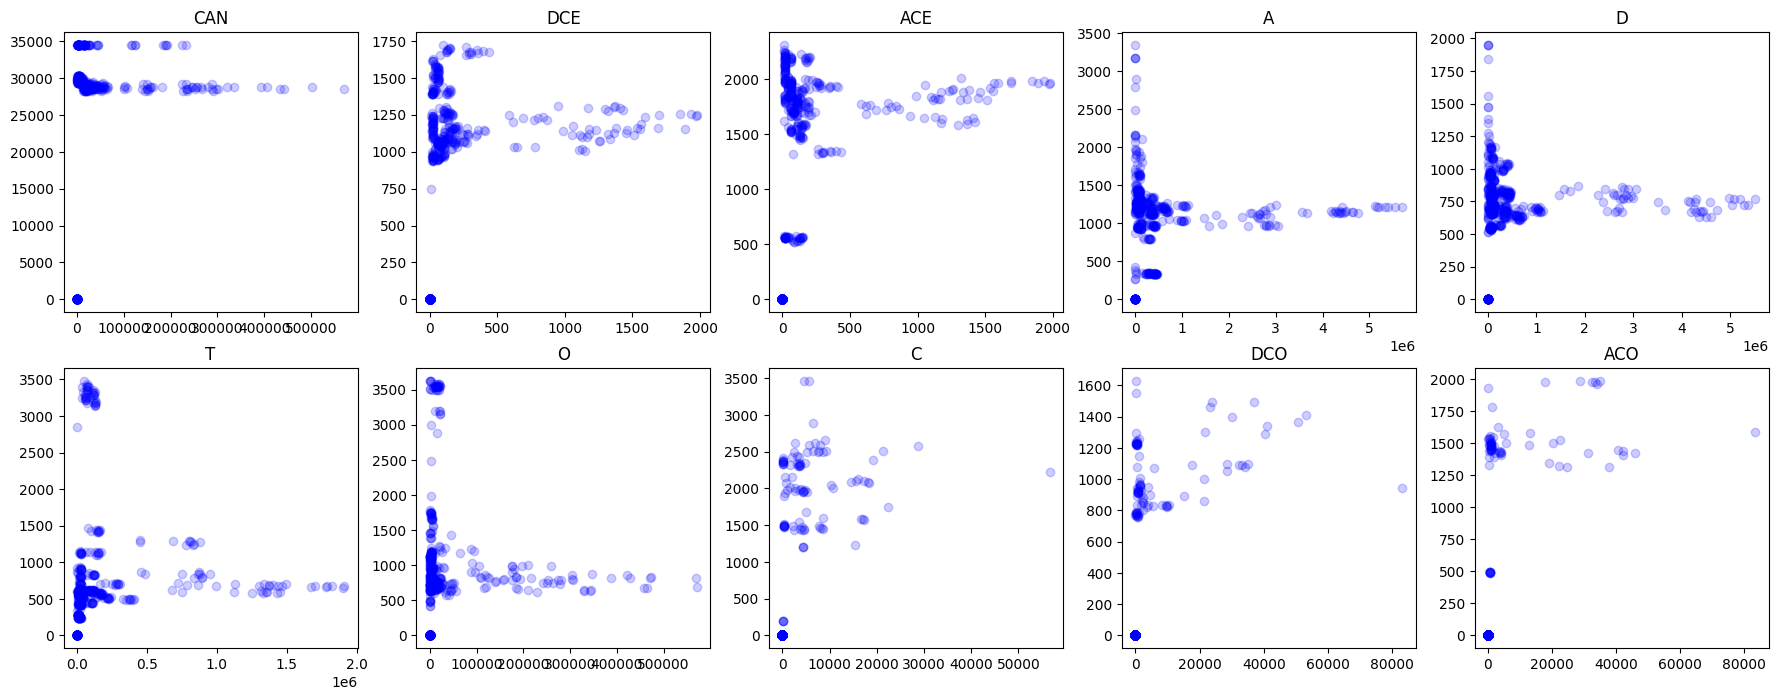

In [105]:
utes = {m: pd.merge(utes_racs[m], utes_prices[m], on='UTE') for m in utes_racs}

fig, ax = plt.subplots(2, 5, figsize=(22, 8))

ax = ax.flatten()
for i, s in enumerate(services):
    ax[i].set_title(s)
    for m in utes:    
        ax[i].scatter(utes[m][f'{s}_racs'], utes[m][f'{s}_pric'], alpha=0.2, color='b')

plt.show()

In [116]:
columns = list(utes['Abr'].columns)
columns.remove('UTE')

columns.insert(0, 'UTE')

for m in utes:
    utes[m] = utes[m][columns]

In [120]:
parent_folder = 'Data'

for month in utes:
    filename = f'UTEs_{month}.xlsx'
    utes[m].to_excel(os.path.join(parent_folder, 'Raciones y precios UTEs', filename), index=False)


In [126]:
parent_folder = 'Data'
folder = 'Raciones'
subfolder = 'Meses'

path = lambda x: os.path.join(parent_folder, folder, subfolder, f'Raciones_{x}.xlsx')

meses = list(utes.keys())

raciones = {}
for m in meses:
    raciones[m] = pd.read_excel(path(m))

In [125]:
services = list(raciones['Abr'].columns)
services.remove('RBD')
rbds = list(cols.RBD.unique())

In [141]:
rac_totales = {'RBD': rbds}

for ser in services:
    rac_totales[ser] = pd.Series([0 for _ in rbds])

    for m in meses:
        rac_totales[ser] += raciones[m][ser]

    rac_totales[ser] = list(rac_totales[ser])

rac_totales = pd.DataFrame(rac_totales)

parent_folder = 'Data'
folder = 'Raciones'
path = os.path.join(parent_folder, folder, 'Raciones_totales.xlsx')

rac_totales.to_excel(path, index=False)

In [147]:
raciones_prom = {'RBD': rbds}

for ser in services:
    raciones_prom[ser] = list(rac_totales[ser] / len(meses))

raciones_prom = pd.DataFrame(raciones_prom)

parent_folder = 'Data'
folder = 'Raciones'
path = os.path.join(parent_folder, folder, 'Raciones_promedio.xlsx')

raciones_prom.to_excel(path, index=False)